## Lab 06: Deep Neural Nets applied to Regression Problem

### Case of study 03: Prediction of Fuel Consumption

### 1. Metadata  
Data study of city-cycle fuel consumption. Next, we have the list of metadata:  
  
* **mpg**: target. You far can travel one automobile per gallon of fuel
* **cylinders**: integer
* **displacement**: continuous
* **house power**: continuous
* **weight**: continuous
* **acceleration**: continuous
* **model year**: integer
* **origin**: categorical [1-US; 2-Europe; 3-Japan]
* **car name**: categorical 

In [ ]:
# import packages
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
# define metadata: columns name
metadata = ["mpg", "cylinders", "displacement", "house_power", "weight", "acceleration", 
            "model_year", "origin"]

### 2. Load dataset

In [4]:
data = pd.read_csv("dataset/auto-mpg.data", names=metadata, na_values="?", sep=" ", comment='\t', skipinitialspace=True)
data.head()

,mpg,cylinders,displacement,house_power,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Filtering missing values

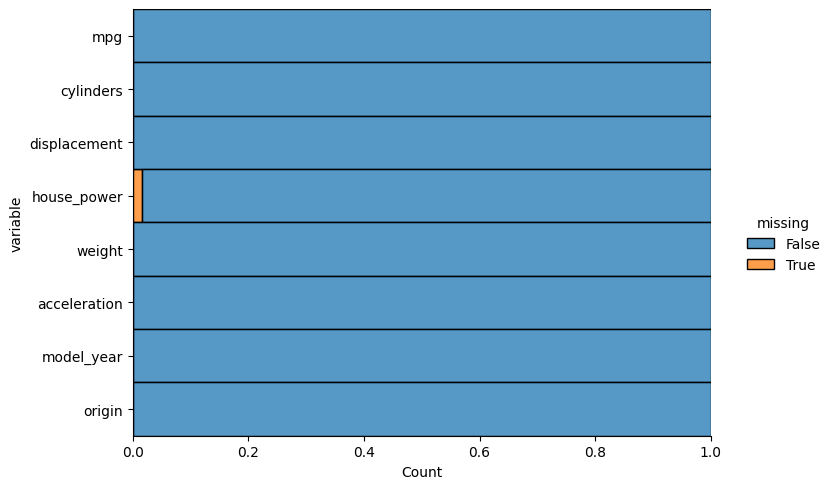

In [5]:
# plot missing data
sbn.displot(
    data = data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5
)

plt.show()

In [6]:
data = data.dropna()
print("#Total samples without missing values = ", len(data))

#Total samples without missing values =  392


### 3. Data Preprocessing

In [7]:
# Split data into features and target
x = data.loc[:, data.columns != "mpg"]
y = data["mpg"].values

In [8]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [9]:
# check dimensionality of each subset of data
print("Dimensions in x-train: ", x_train.shape)
print("Dimensions in y-train: ", y_train.shape)
print("Dimensions in x-test: ", x_test.shape)
print("Dimensions in y-test: ", y_test.shape)

Dimensions in x-train:  (313, 7)
Dimensions in y-train:  (313,)
Dimensions in x-test:  (79, 7)
Dimensions in y-test:  (79,)


In [10]:
# math transformations for features
transformer = ColumnTransformer(transformers = [
    ("num", StandardScaler(), ["cylinders", "displacement", "house_power", "weight", "acceleration", "model_year"]),
    ("cat", OneHotEncoder(), ["origin"])
])

In [11]:
# transformer will learn only from training data
transformer.fit(x_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['cylinders', 'displacement', 'house_power',
                                  'weight', 'acceleration', 'model_year']),
                                ('cat', OneHotEncoder(), ['origin'])])

In [12]:
# transformer will apply in the train and test data
x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)

In [14]:
# convert data to Pytorch tensor data structure
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [15]:
print("dim x-train tensor: ", x_train_tensor.shape)
print("y-train tensor: ", y_train_tensor.shape)

dim x-train tensor:  torch.Size([313, 9])
y-train tensor:  torch.Size([313, 1])


In [16]:
# Create DataLoaders with batches of data
# this is for batch-stochastic gradient descendent
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### 4. Build Model Architecture

In [17]:
# pytorch class to define regressor architecture
class RegressionNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_func):
        super(RegressionNeuralNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_layers
        self.activation_dict = {
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh()
        }

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(in_features=layer_sizes[i], out_features=layer_sizes[i+1])) #linear comb
            layers.append(self.activation_dict[activation_func])    # activation function
        layers.append(nn.Linear(in_features=layer_sizes[-1], out_features=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [18]:
# define list of experiments
experiments = [
    {'hidden_layers': [32, 16], 'activation': 'relu'},
    {'hidden_layers': [64, 32, 16], 'activation': 'relu'},
    {'hidden_layers': [32, 16], 'activation': 'sigmoid'},
    {'hidden_layers': [64, 32, 16], 'activation': 'sigmoid'},
    {'hidden_layers': [32, 16], 'activation': 'tanh'},
    {'hidden_layers': [64, 32, 16], 'activation': 'tanh'},
]

### 5. Training/Test process

In [19]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
# Define the training function
def train_model(model, train_loader, test_loader, device, num_epochs=200):
    criterion = nn.MSELoss()    #loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    test_losses = []

    # for each iteration
    for epoch in range(num_epochs):
        # training
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # validation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

    return train_losses, test_losses


In [21]:
def run_training(input_size, experiments, train_loader, test_loader, x_test_tensor, y_test, device):    

    experiment_results = []

    for experiment in experiments:
        print(f"Run experiment with hidden layers: {experiment['hidden_layers']}, activation: {experiment['activation']}")

        model = RegressionNeuralNet(input_size=input_size,
                                    hidden_layers=experiment['hidden_layers'],
                                    activation_func=experiment['activation']).to(device)

        start_time = time.time()
        train_losses, test_losses = train_model(model, train_loader, test_loader, device)
        end_time = time.time()

        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # testing        
        model.eval()
        with torch.no_grad():
            y_pred = model(x_test_tensor.to(device)).cpu().detach().numpy()
        
        # calculate metrics for model quality
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R^2: {r2:.4f}")

        experiment_results.append({
            'experiment': experiment,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'mse': mse,
            'r2': r2,
            'training_time': training_time
        })

    return experiment_results

In [22]:
# run the training/test process
exp_results = run_training(x_train.shape[1], experiments, train_loader, test_loader, x_test_tensor, y_test, device)

Run experiment with hidden layers: [32, 16], activation: relu
Training time: 24.78 seconds
Mean Squared Error: 5.5775
R^2: 0.9103
Run experiment with hidden layers: [64, 32, 16], activation: relu
Training time: 19.10 seconds
Mean Squared Error: 6.7141
R^2: 0.8920
Run experiment with hidden layers: [32, 16], activation: sigmoid
Training time: 16.40 seconds
Mean Squared Error: 12.0894
R^2: 0.8055
Run experiment with hidden layers: [64, 32, 16], activation: sigmoid
Training time: 19.71 seconds
Mean Squared Error: 11.4464
R^2: 0.8158
Run experiment with hidden layers: [32, 16], activation: tanh
Training time: 15.82 seconds
Mean Squared Error: 9.1569
R^2: 0.8527
Run experiment with hidden layers: [64, 32, 16], activation: tanh
Training time: 17.01 seconds
Mean Squared Error: 9.4522
R^2: 0.8479


### 6. Monitoring results

In [23]:
def monitoring_results(experiment_results):

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 25))

    # Plot train and test loss by epoch for each experiment
    for result in experiment_results:
        experiment = result['experiment']
        axes[0].plot(result['train_losses'], label=f"Train: {experiment['hidden_layers']} layers, {experiment['activation']}")
        axes[1].plot(result['test_losses'], label=f"Test: {experiment['hidden_layers']} layers, {experiment['activation']}")
    
    # training loss report
    axes[0].set_title('Training Loss by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # test loss report
    axes[1].set_title('Testing Loss by Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    experiment_labels = [f"{exp['hidden_layers']} layers, {exp['activation']}" for exp in experiments]

    # Plot Mean Squared Error for each experiment    
    mses = [result['mse'] for result in experiment_results]    
    bars_mse = axes[2].bar(experiment_labels, mses)
    axes[2].set_title('Mean Squared Error by Experiment')
    axes[2].set_xlabel('Experiment')
    axes[2].set_ylabel('MSE')
    axes[2].set_ylim(0, max(mses) + 1)
    axes[2].set_xticks(range(len(experiment_labels)))
    axes[2].set_xticklabels(experiment_labels, rotation = 45, ha = 'right')

    # Annotate MSE bars
    for bar in bars_mse:
        yval = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # por R^2 for each experiment
    r2s = [result['r2'] for result in experiment_results]    
    bars_r2 = axes[3].bar(experiment_labels, r2s)
    axes[3].set_title('R^2 by Experiment')
    axes[3].set_xlabel('Experiment')
    axes[3].set_ylabel('R^2')
    axes[3].set_ylim(0, 1)
    axes[3].set_xticks(range(len(experiment_labels)))
    axes[3].set_xticklabels(experiment_labels, rotation = 45, ha = 'right')

    # Annotate R^2 bars
    for bar in bars_r2:
        yval = bar.get_height()
        axes[3].text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    

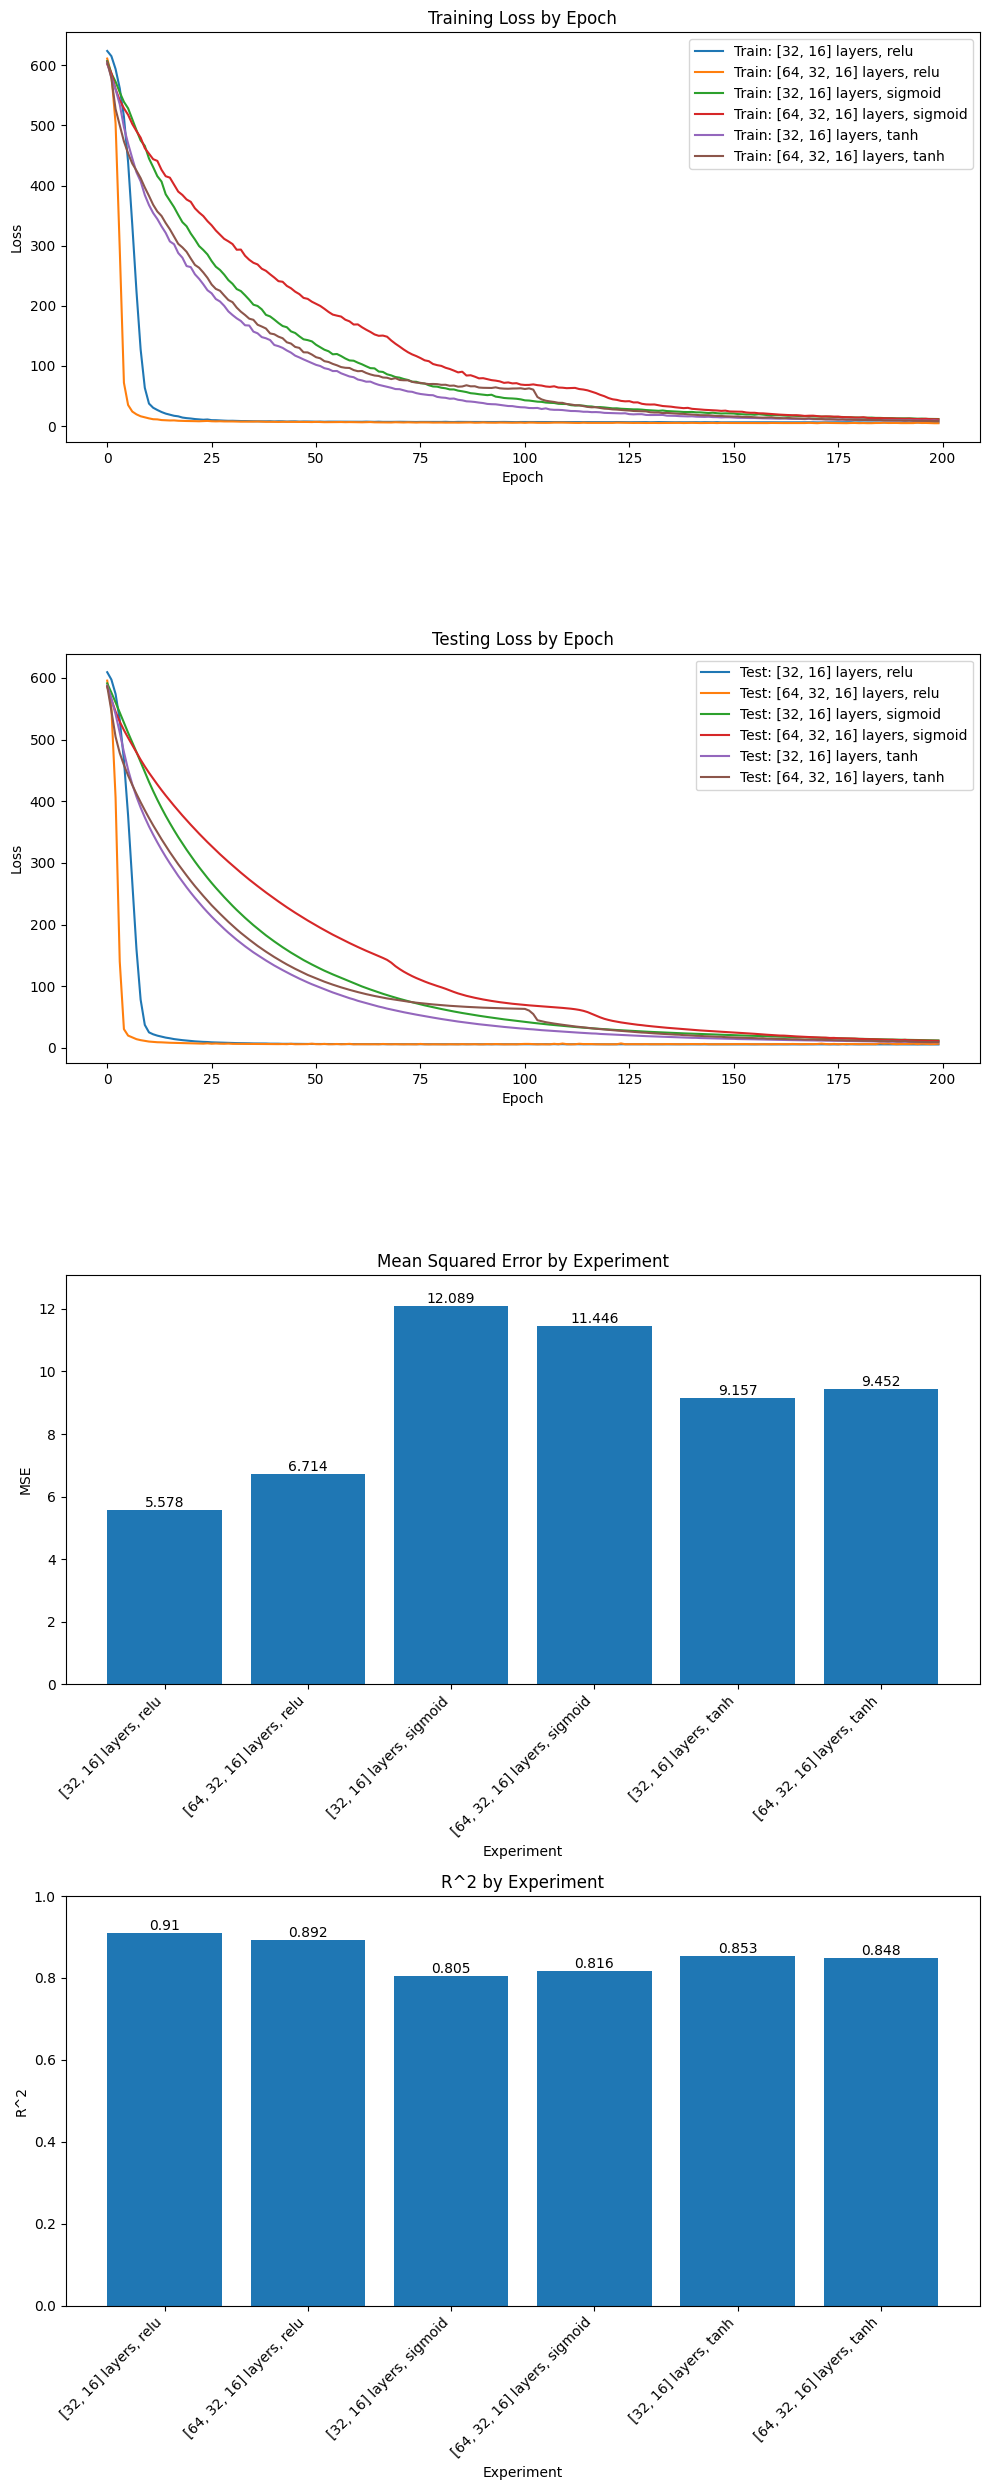

In [24]:
monitoring_results(exp_results)